# Covert Datasets

## PyTorch

### Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Datasets

In [4]:
# Load the dataset
data = pd.read_csv('compressed_data.csv')

# Check for NaN values
print(f"NaN values in dataset: {data.isna().sum().sum()}")

# Handle NaN values
data = data.fillna(data.mean())  # Fill numerical NaNs with mean values

# Separate features and target
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type']

# Check for NaNs in y (target)
print(f"NaN values in target: {y.isna().sum()}")

# Handle NaN values in target if any exist
if y.isna().sum() > 0:
    # Option 1: Remove rows with NaN targets (better approach for targets)
    valid_indices = ~y.isna()
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"Removed {sum(~valid_indices)} rows with NaN targets")

# Check the number of classes for the classification task
num_classes = len(y.unique())
print(f"Number of unique classes: {num_classes}")

# Convert target labels to start from 0 (if they don't already)
y = y - 1 if y.min() > 0 else y
# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final check for any remaining NaN values after preprocessing
if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
    print("Warning: NaN values remain after preprocessing. Fixing...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

# Create a PyTorch dataset class
class ForestCoverDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataset objects
train_dataset = ForestCoverDataset(X_train_scaled, y_train.values)
test_dataset = ForestCoverDataset(X_test_scaled, y_test.values)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

NaN values in dataset: 0
NaN values in target: 0
Number of unique classes: 7


### Model

In [12]:
# Define the MLP model architecture
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.3):
        super(MLPClassifier, self).__init__()

        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dims[0]))
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define hyperparameters
input_dim = X_train_scaled.shape[1]
hidden_dims = [128, 64, 32]  # Multiple hidden layers
output_dim = num_classes
learning_rate = 0.001
num_epochs = 50

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLPClassifier(input_dim, hidden_dims, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


Using device: cpu


### Training & Evaluation

Starting training...
Epoch 5/50, Train Loss: 0.5336, Train Acc: 0.7760, Test Loss: 0.4584
Epoch 10/50, Train Loss: 0.5077, Train Acc: 0.7885, Test Loss: 0.4333
Epoch 15/50, Train Loss: 0.4923, Train Acc: 0.7955, Test Loss: 0.4124
Epoch 20/50, Train Loss: 0.4855, Train Acc: 0.7977, Test Loss: 0.4018
Epoch 25/50, Train Loss: 0.4796, Train Acc: 0.8020, Test Loss: 0.3955
Epoch 30/50, Train Loss: 0.4743, Train Acc: 0.8036, Test Loss: 0.3883
Epoch 35/50, Train Loss: 0.4706, Train Acc: 0.8051, Test Loss: 0.3816
Epoch 40/50, Train Loss: 0.4684, Train Acc: 0.8073, Test Loss: 0.3791
Epoch 45/50, Train Loss: 0.4653, Train Acc: 0.8087, Test Loss: 0.3735
Epoch 50/50, Train Loss: 0.4642, Train Acc: 0.8090, Test Loss: 0.3749
Training complete!

Evaluation Metrics:
Accuracy: 0.8550
Precision: 0.8554
F1 Score: 0.8521
Macro AUC: 0.9821
Micro AUC: 0.9880


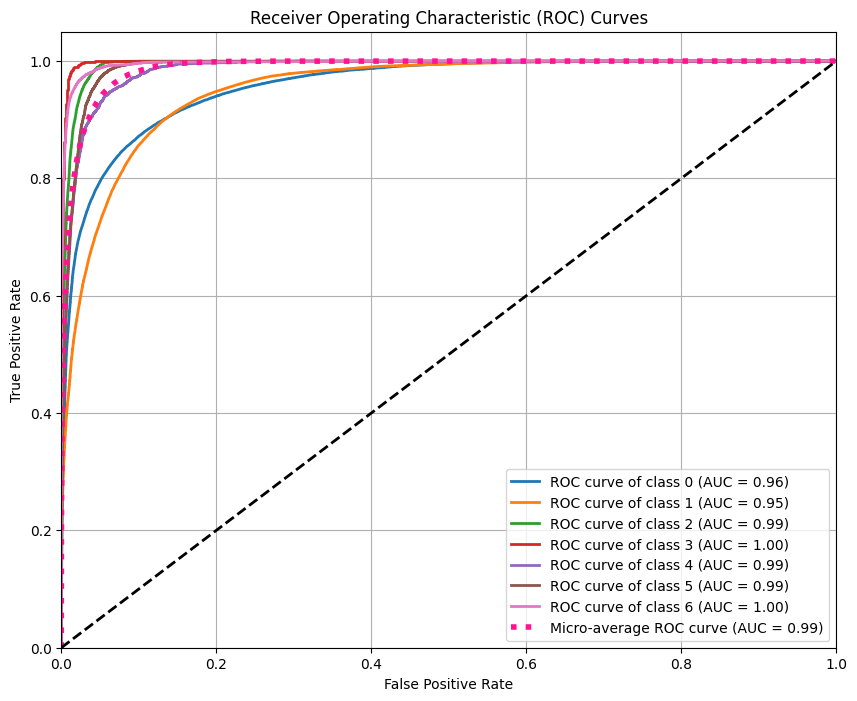

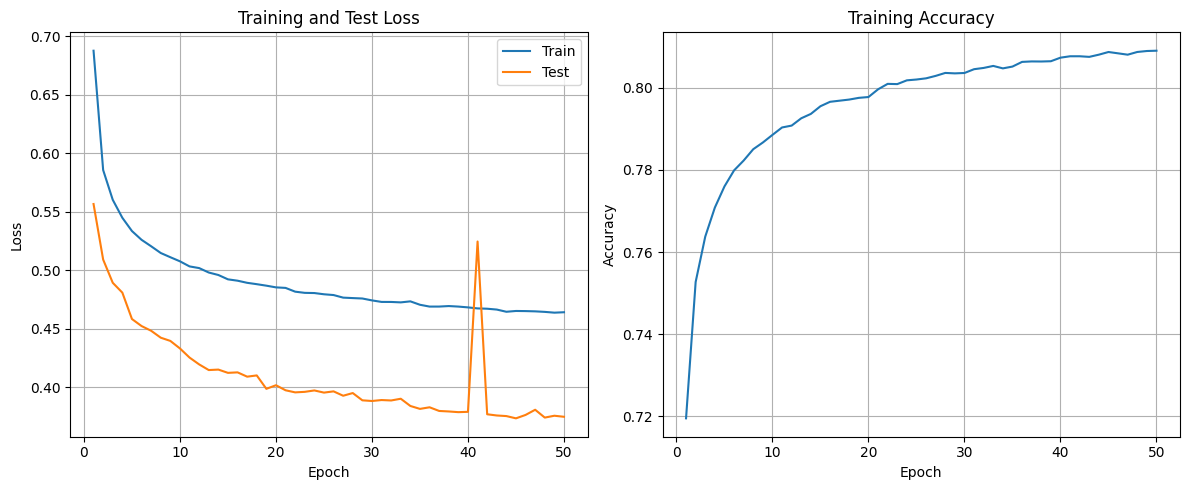

Model saved to 'forest_cover_mlp_model.pth'


In [16]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Additional check for NaN values in batches
        if torch.isnan(inputs).any():
            inputs = torch.nan_to_num(inputs)

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Additional check for NaN values in batches
            if torch.isnan(inputs).any():
                inputs = torch.nan_to_num(inputs)

            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return test_loss, all_preds, all_labels, all_probs

# Train the model
train_losses = []
train_accs = []
test_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    try:
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        test_loss, test_preds, test_labels, test_probs = evaluate_model(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)

        # Update learning rate scheduler
        scheduler.step(test_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}")

    except RuntimeError as e:
        print(f"Error in epoch {epoch+1}: {e}")
        # Check for NaN values
        for name, param in model.named_parameters():
            if torch.isnan(param.data).any():
                print(f"NaN detected in parameter {name}")
        break

print("Training complete!")
# Final evaluation
try:
    _, test_preds, test_labels, test_probs = evaluate_model(model, test_loader, criterion, device)

    # Calculate evaluation metrics
    # For multi-class classification, we need to use appropriate averaging methods
    accuracy = accuracy_score(test_labels, test_preds)
    precision = precision_score(test_labels, test_preds, average='weighted')
    f1 = f1_score(test_labels, test_preds, average='weighted')

    # For ROC and AUC in multi-class setting, we use One-vs-Rest approach
    # Convert class labels to one-hot encoding
    from sklearn.preprocessing import label_binarize
    test_labels_binarized = label_binarize(test_labels, classes=range(num_classes))

    # Calculate ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_probs[:, i])
        roc_auc[i] = roc_auc_score(test_labels_binarized[:, i], test_probs[:, i])

    # Calculate the micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_binarized.ravel(), np.concatenate([test_probs[:, i].reshape(-1, 1) for i in range(num_classes)], axis=1).ravel())
    roc_auc["micro"] = roc_auc_score(test_labels_binarized.ravel(), np.concatenate([test_probs[:, i].reshape(-1, 1) for i in range(num_classes)], axis=1).ravel())

    # Calculate macro-average AUC
    roc_auc["macro"] = np.mean([roc_auc[i] for i in range(num_classes)])

    # Print evaluation metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Macro AUC: {roc_auc['macro']:.4f}")
    print(f"Micro AUC: {roc_auc['micro']:.4f}")
     # Plot ROC curve
    plt.figure(figsize=(10, 8))

    # Plot ROC curves for each class
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot the diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train')
    plt.plot(range(1, len(test_losses)+1), test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs)+1), train_accs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save the model
    torch.save(model.state_dict(), 'forest_cover_mlp_model.pth')
    print("Model saved to 'forest_cover_mlp_model.pth'")

except Exception as e:
    print(f"Error during evaluation: {e}")


## TensorFlow

### Library

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize

### Datasets

In [18]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
print("Loading and preprocessing data...")
data = pd.read_csv('compressed_data.csv')

# Check for NaN values
print(f"NaN values in dataset: {data.isna().sum().sum()}")

# Handle NaN values
data = data.fillna(data.mean())  # Fill numerical NaNs with mean values

# Separate features and target
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type']

# Check for NaNs in y (target)
print(f"NaN values in target: {y.isna().sum()}")

# Handle NaN values in target if any exist
if y.isna().sum() > 0:
    # Remove rows with NaN targets
    valid_indices = ~y.isna()
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"Removed {sum(~valid_indices)} rows with NaN targets")

# Check the number of classes for the classification task
num_classes = len(y.unique())
print(f"Number of unique classes: {num_classes}")

# Convert target labels to start from 0 (if they don't already)
if y.min() > 0:
    y = y - 1
    print("Adjusted target labels to start from 0")

# One-hot encode the target for TensorFlow
y_onehot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test, y_onehot_train, y_onehot_test = train_test_split(
    X, y, y_onehot, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final check for any remaining NaN values after preprocessing
if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
    print("Warning: NaN values remain after preprocessing. Fixing...")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

Loading and preprocessing data...
NaN values in dataset: 0
NaN values in target: 0
Number of unique classes: 7
Adjusted target labels to start from 0


### Model

In [19]:
# Define the MLP model using TensorFlow/Keras
def create_model(input_dim, hidden_dims, output_dim, dropout_rate=0.3):
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_dims[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Hidden layers
    for units in hidden_dims[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim, activation='softmax'))

    return model

# Define hyperparameters
input_dim = X_train_scaled.shape[1]
hidden_dims = [128, 64, 32]  # Multiple hidden layers
output_dim = num_classes
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Create the model
print("Creating and compiling model...")
model = create_model(input_dim, hidden_dims, output_dim)

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Callbacks for training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Custom callback to handle NaN values during training
class NanHandler(tf.keras.callbacks.Callback):
    def on_batch_begin(self, batch, logs=None):
        # Check weights for NaN values
        for layer in self.model.layers:
            weights = layer.get_weights()
            for w in weights:
                if np.isnan(w).any():
                    print(f"NaN detected in weights of layer {layer.name}")
                    # Replace NaNs with zeros
                    w[np.isnan(w)] = 0.0

    def on_epoch_end(self, epoch, logs=None):
        # Handle potential NaN in metrics
        for k, v in logs.items():
            if np.isnan(v):
                print(f"NaN detected in metric {k}, setting to zero")
                logs[k] = 0.0

# Add the NaN handler callback
callbacks.append(NanHandler())

Creating and compiling model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,503 (72.28 KB)

 Trainable params: 18,055 (70.53 KB)

 Non-trainable params: 448 (1.75 KB)

### Training & Evaluation

Starting training...
Epoch 1/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - accuracy: 0.6546 - loss: 0.8994 - val_accuracy: 0.7632 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 2/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.7410 - loss: 0.6105 - val_accuracy: 0.7831 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 3/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.7552 - loss: 0.5753 - val_accuracy: 0.7936 - val_loss: 0.4917 - learning_rate: 0.0010
Epoch 4/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.7647 - loss: 0.5557 - val_accuracy: 0.8047 - val_loss: 0.4743 - learning_rate: 0.0010
Epoch 5/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.7710 - loss: 0.5428 - val_accuracy: 0.8102 - val_loss: 0.4655 - learning_rate: 0.0010
Epoch 6/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.7766 - loss: 0.5331 - val_accuracy: 0.8156 - val_loss: 0.4577 - learning_rate: 0.0010
Epoch 7/50
6355/6355 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms

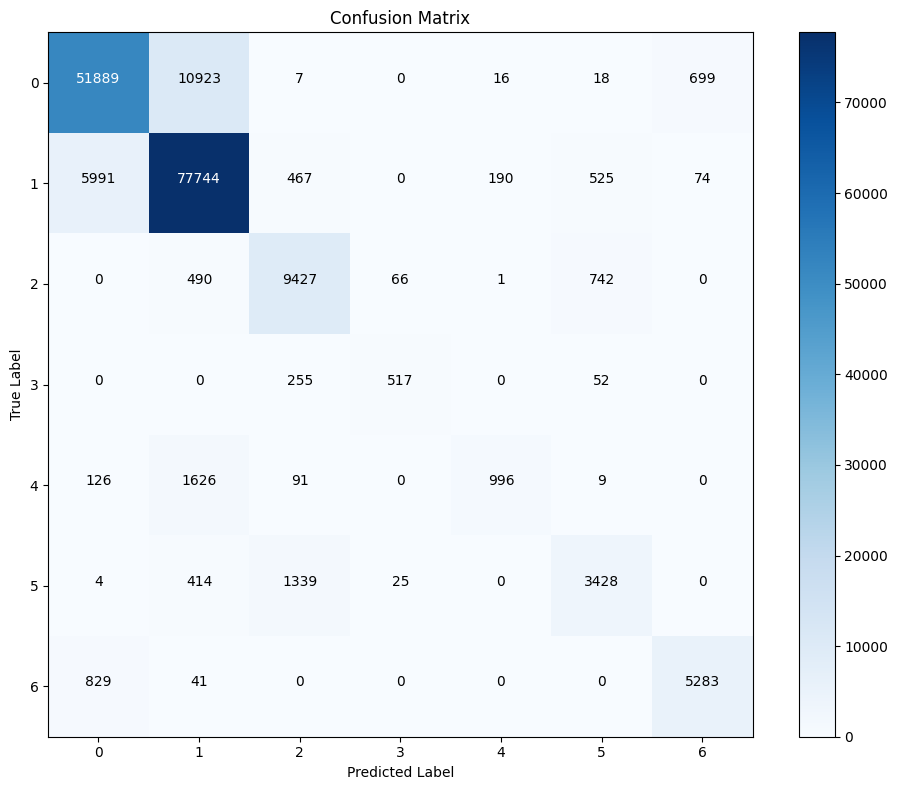

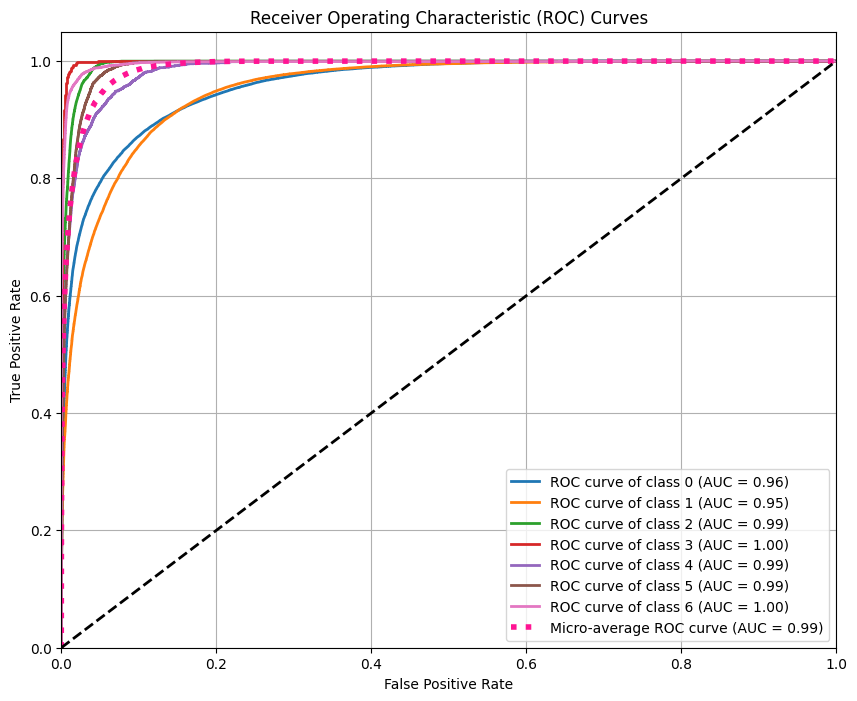

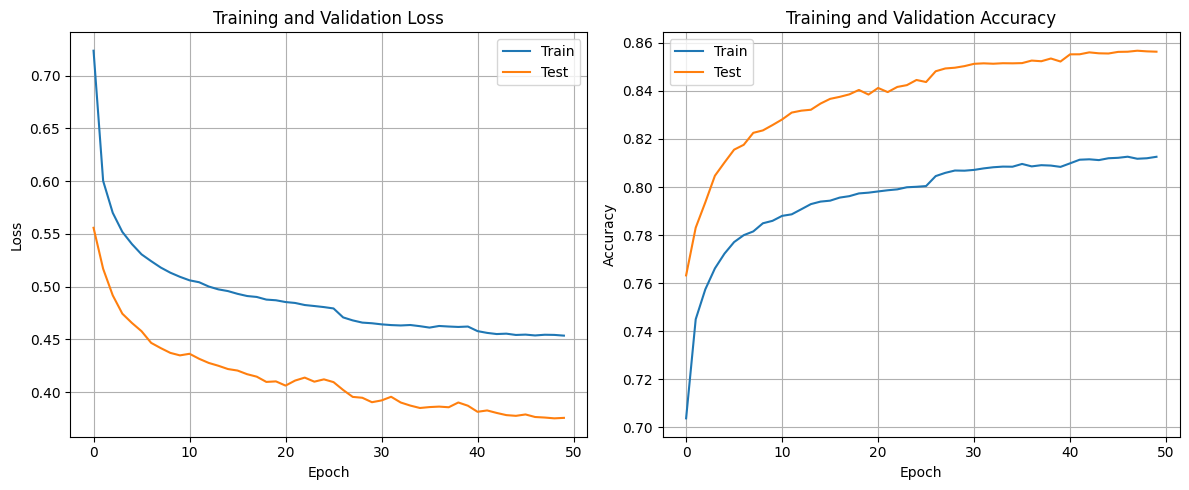

Model saved to 'forest_cover_tf_model.h5'

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     63552
           1       0.85      0.91      0.88     84991
           2       0.81      0.88      0.85     10726
           3       0.85      0.63      0.72       824
           4       0.83      0.35      0.49      2848
           5       0.72      0.66      0.69      5210
           6       0.87      0.86      0.87      6153

    accuracy                           0.86    174304
   macro avg       0.83      0.73      0.76    174304
weighted avg       0.86      0.86      0.85    174304



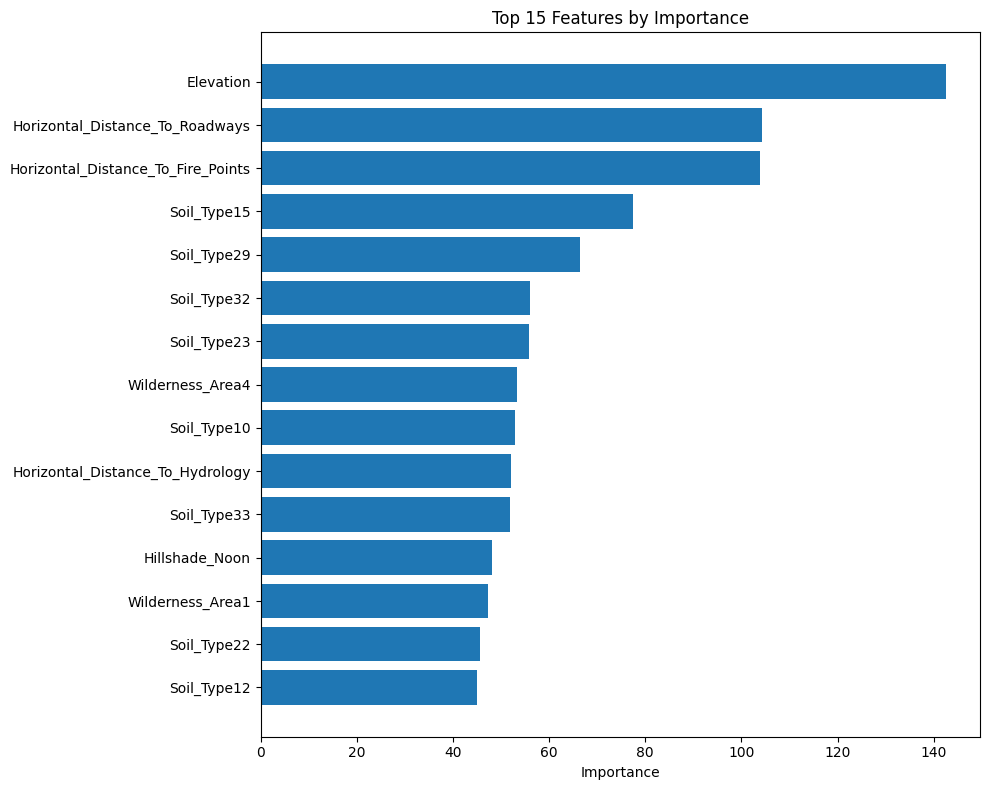


Top 10 Most Important Features:
                               Feature  Importance
0                            Elevation  142.517349
5      Horizontal_Distance_To_Roadways  104.322746
9   Horizontal_Distance_To_Fire_Points  103.858063
25                         Soil_Type15   77.534088
39                         Soil_Type29   66.386795
42                         Soil_Type32   55.989998
33                         Soil_Type23   55.897156
53                    Wilderness_Area4   53.286964
20                         Soil_Type10   52.900192
3     Horizontal_Distance_To_Hydrology   52.056084


In [20]:
# Train the model
print("Starting training...")
try:
    history = model.fit(
        X_train_scaled, y_onehot_train,
        validation_data=(X_test_scaled, y_onehot_test),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    print("Training complete!")
except Exception as e:
    print(f"Error during training: {e}")
    # Check if any layer weights contain NaN
    for layer in model.layers:
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            if np.isnan(w).any():
                print(f"NaN weights in layer {layer.name}, weight index {i}")

# Evaluate the model
print("Evaluating model...")
try:
    # Get model predictions
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Get raw class labels from one-hot encoded test data
    y_test_classes = np.argmax(y_onehot_test, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

    # For ROC and AUC in multi-class setting, we use One-vs-Rest approach
    # Check if we need to binarize test labels (should already be one-hot encoded)
    test_labels_binarized = y_onehot_test

    # Calculate ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = roc_auc_score(test_labels_binarized[:, i], y_pred_probs[:, i])

    # Calculate the micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_binarized.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = roc_auc_score(test_labels_binarized.ravel(), y_pred_probs.ravel())

    # Calculate macro-average AUC
    roc_auc["macro"] = np.mean([roc_auc[i] for i in range(num_classes)])

    # Print evaluation metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Macro AUC: {roc_auc['macro']:.4f}")
    print(f"Micro AUC: {roc_auc['micro']:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig('tf_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(10, 8))

    # Plot ROC curves for each class
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot the diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('tf_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('tf_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save the model
    model.save('forest_cover_tf_model.h5')
    print("Model saved to 'forest_cover_tf_model.h5'")
except Exception as e:
    print(f"Error during evaluation: {e}")

# Bonus: Generate a classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Bonus: Feature importance analysis
# We can approximate feature importance by examining weights of the first layer
def analyze_feature_importance(model, feature_names):
    # Get weights from first dense layer
    weights = model.layers[0].get_weights()[0]

    # Calculate importance as the absolute sum of weights for each feature
    importance = np.sum(np.abs(weights), axis=1)

    # Create DataFrame with feature names and importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    return feature_importance

# Get feature importance
feature_names = X.columns
try:
    feature_importance = analyze_feature_importance(model, feature_names)

    # Plot top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])
    plt.xlabel('Importance')
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.savefig('tf_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
except Exception as e:
    print(f"Error analyzing feature importance: {e}")